In [31]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from pylab import rcParams
from pandas import TimeGrouper
import statsmodels.tsa.stattools as tsa
rcParams['figure.figsize'] = 16,4

# Show the fraction of data set

df = pd.read_csv('database.csv', low_memory=False)
df.head()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


In [14]:
df.Month = pd.to_datetime(df.Month, format='%B').dt.month.map("{:02}".format)
df['Date'] = df.apply(lambda row: '{}-{}'.format(row.Year, row.Month), axis=1)
df.reset_index()
df.Date = pd.to_datetime(df.Date, format='%Y-%m')
df.head()

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source,Date
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,01,1,Murder or Manslaughter,...,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI,1980-01-01
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,03,1,Murder or Manslaughter,...,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI,1980-03-01
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,03,2,Murder or Manslaughter,...,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI,1980-03-01
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,04,1,Murder or Manslaughter,...,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI,1980-04-01
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,04,2,Murder or Manslaughter,...,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI,1980-04-01


In [13]:
# Create Date field

df.Month = pd.to_datetime(df.Month, format='%B').dt.month.map("{:02}".format)
df['Date'] = df.apply(lambda row: '{}-{}'.format(row.Year, row.Month), axis=1)
df.reset_index()
df.Date = pd.to_datetime(df.Date, format='%Y-%m')
df.head()

State,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,119,1,105,39,2992,20,15,4,190,438,...,0,112,1642,6,1,44,30,10,17,1
1980-02-01,63,8,75,21,2526,54,7,30,120,283,...,1,140,2077,9,1,40,14,13,40,3
1980-03-01,103,3,49,19,2346,16,24,2,91,385,...,0,124,3426,4,0,60,30,6,71,3
1980-04-01,72,4,106,55,3743,39,49,5,105,272,...,0,177,1908,1,0,49,38,4,23,2
1980-05-01,78,4,70,29,2854,76,10,1,153,1143,...,2,234,2065,6,0,63,44,17,22,1


In [15]:
# Aggregate data summing month incident for every state

states = df[['Date', 'State', 'Incident']]
states = states.groupby(['Date', 'State'])['Incident'].sum().unstack()
states = states.fillna(0)
states.reset_index()
states.head()

State,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,119.0,1.0,105.0,39.0,2992.0,20.0,15.0,4.0,190.0,438.0,...,0.0,112.0,1642.0,6.0,1.0,44.0,30.0,10.0,17.0,1.0
1980-02-01,63.0,8.0,75.0,21.0,2526.0,54.0,7.0,30.0,120.0,283.0,...,1.0,140.0,2077.0,9.0,1.0,40.0,14.0,13.0,40.0,3.0
1980-03-01,103.0,3.0,49.0,19.0,2346.0,16.0,24.0,2.0,91.0,385.0,...,0.0,124.0,3426.0,4.0,0.0,60.0,30.0,6.0,71.0,3.0
1980-04-01,72.0,4.0,106.0,55.0,3743.0,39.0,49.0,5.0,105.0,272.0,...,0.0,177.0,1908.0,1.0,0.0,49.0,38.0,4.0,23.0,2.0
1980-05-01,78.0,4.0,70.0,29.0,2854.0,76.0,10.0,1.0,153.0,1143.0,...,2.0,234.0,2065.0,6.0,0.0,63.0,44.0,17.0,22.0,1.0


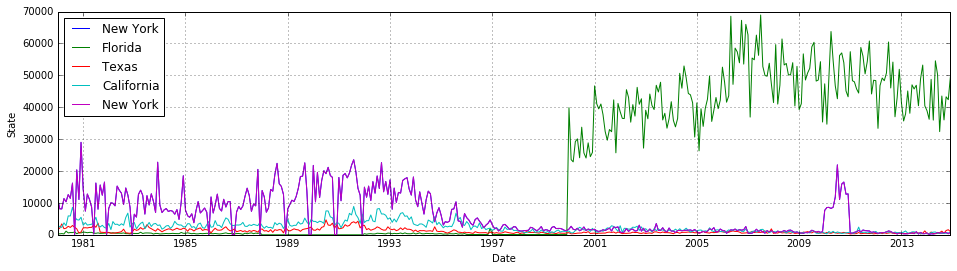

In [16]:
# Plot several state time series

my_series = pd.DataFrame()
i = 0
for state in list(states):
    my_series[state] = states[states.columns[i]]
    i += 1
fig = plt.figure()
ax = plt.subplot(111)
for state in ['New York','Florida', 'Texas', 'California', 'New York']:
    ax.plot(my_series[state], linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

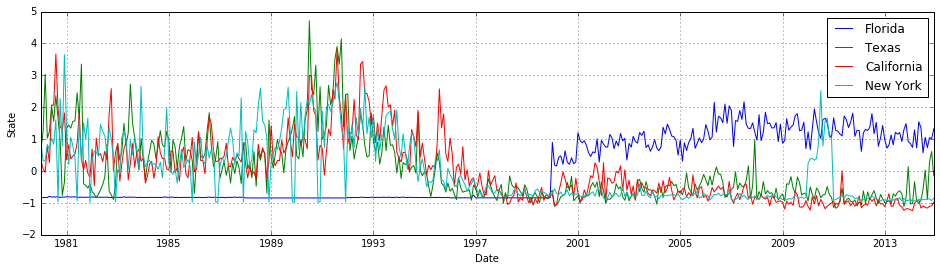

In [17]:
# Normalize and plot several state time series

my_series = pd.DataFrame()
i = 0
for state in list(states):
    my_series[state] = states[states.columns[i]]
    i += 1
fig = plt.figure()
ax = plt.subplot(111)
for state in ['Florida', 'Texas', 'California', 'New York']:
    ax.plot((my_series[state] - my_series[state].mean()) / my_series[state].std(), linestyle='-',
            label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

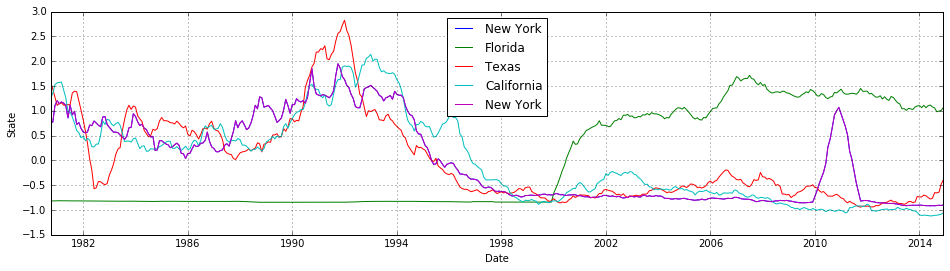

In [18]:
my_series = pd.DataFrame()
i = 0
for state in list(states):
    my_series[state] = states[states.columns[i]]
    i += 1
fig = plt.figure()
ax = plt.subplot(111)
for state in ['New York', 'Florida', 'Texas', 'California', 'New York']:
    # ax.plot(my_series[state], linestyle='-', label="{}".format(state))
    ax.plot(((my_series[state] - my_series[state].mean()) / my_series[state].std()).rolling(window=10).mean(), linestyle='-',
            label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

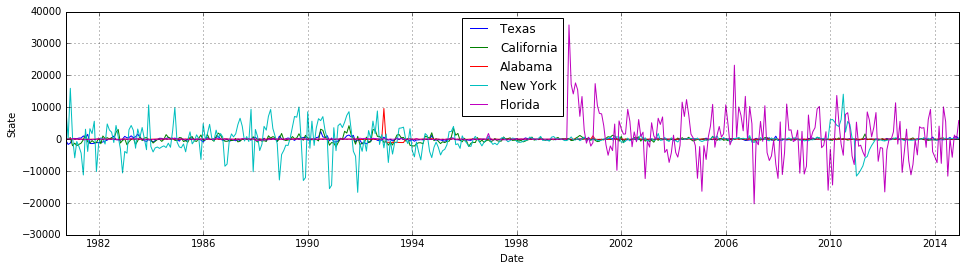

In [19]:
my_series = pd.DataFrame()
i = 0
for state in list(states):
    my_series[state] = states[states.columns[i]]
    i += 1
fig = plt.figure()
ax = plt.subplot(111)
for state in ['Texas', 'California', 'Alabama', 'New York', 'Florida']:
    ax.plot(my_series[state] - my_series[state].rolling(window=10).mean(), linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

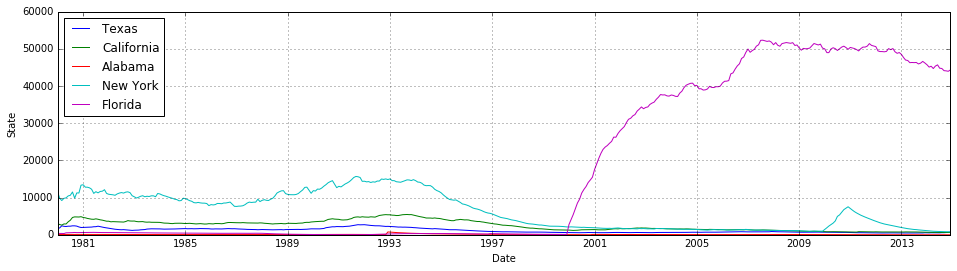

In [20]:
# Calculate exponential weighted mean (EWM)

my_series = pd.DataFrame()
i = 0
for state in list(states):
    my_series[state] = states[states.columns[i]]
    i += 1
fig = plt.figure()
ax = plt.subplot(111)
for state in ['Texas', 'California', 'Alabama', 'New York', 'Florida']:
    ax.plot(my_series[state].ewm(halflife=10).mean(), linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

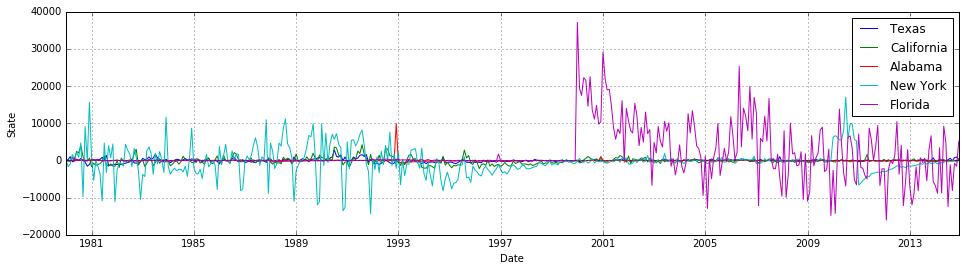

In [21]:
# Removing linear trend

my_series = pd.DataFrame()
i = 0
for state in list(states):
    my_series[state] = states[states.columns[i]]
    i += 1
fig = plt.figure()
ax = plt.subplot(111)
for state in ['Texas', 'California', 'Alabama', 'New York', 'Florida']:
    ax.plot(my_series[state] - my_series[state].ewm(halflife=10).mean(), linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


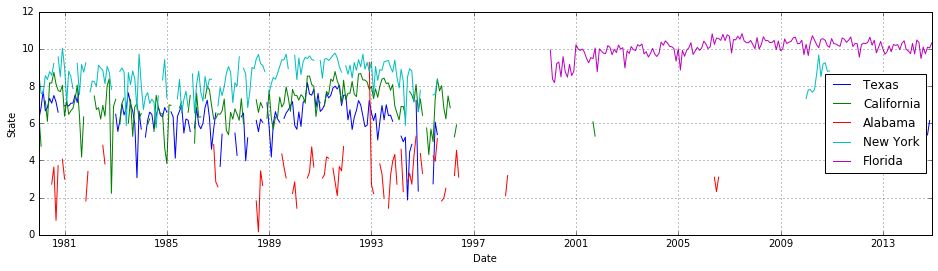

In [22]:
my_series = pd.DataFrame()
i = 0
for state in list(states):
    my_series[state] = states[states.columns[i]]
    i += 1
fig = plt.figure()
ax = plt.subplot(111)
for state in ['Texas', 'California', 'Alabama', 'New York', 'Florida']:
    ax.plot(np.log(my_series[state] - my_series[state].mean()), linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

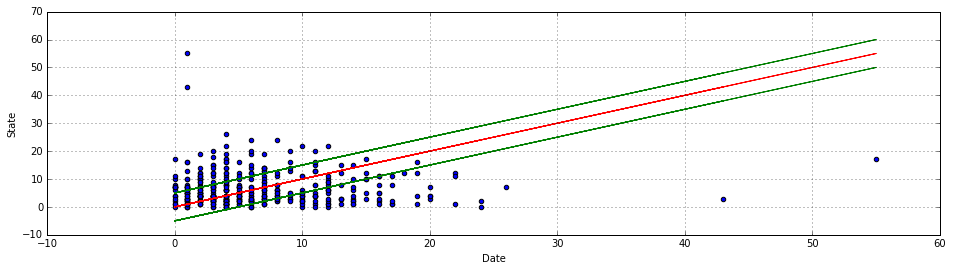

In [23]:
# Test for randomness (lag_plot): Alaska

my_series = pd.DataFrame()
i = 0
for state in list(states):
    my_series[state] = states[states.columns[i]]
    i += 1
fig = plt.figure()
ax = plt.subplot(111)
for state in ['Alaska']:
    ts = my_series[state]
    lag_plot(ts)
    ax.plot(ts, ts, 'r-')
    ax.plot(ts, ts + 5, 'g-')
    ax.plot(ts, ts - 5, 'g-')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

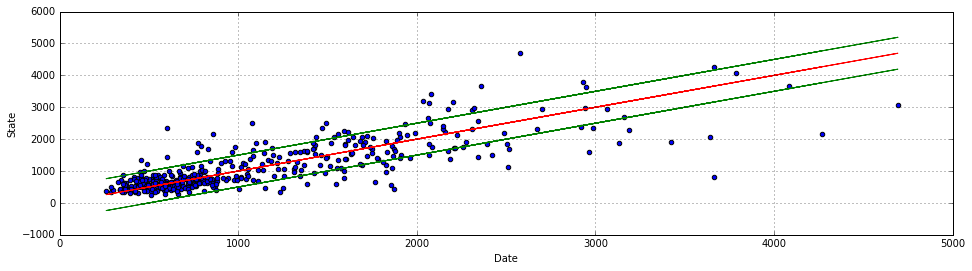

In [28]:
# Test for randomness (lag_plot): Texas

my_series = pd.DataFrame()
i = 0
for state in list(states):
    my_series[state] = states[states.columns[i]]
    i += 1
fig = plt.figure()
ax = plt.subplot(111)
for state in ['Texas']:
    ts = my_series[state]
    lag_plot(ts)
    ax.plot(ts, ts, 'r-')
    ax.plot(ts, ts + 500, 'g-')
    ax.plot(ts, ts - 500, 'g-')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

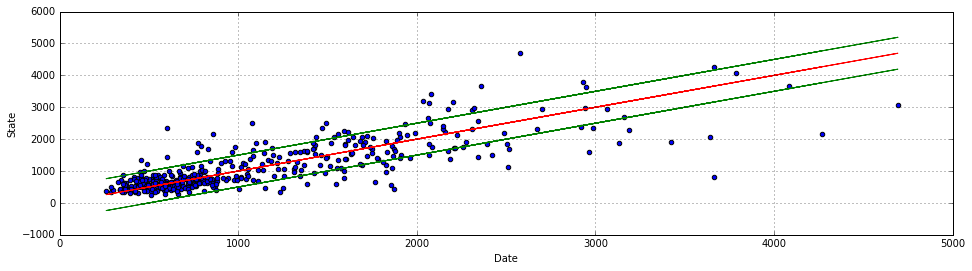

In [29]:
my_series = pd.DataFrame()
i = 0
for state in list(states):
    my_series[state] = states[states.columns[i]]
    i += 1
fig = plt.figure()
ax = plt.subplot(111)
for state in ['Texas']:
    ts = my_series[state]
    lag_plot(ts)
    ax.plot(ts, ts, 'r-')
    ax.plot(ts, ts + 500, 'g-')
    ax.plot(ts, ts - 500, 'g-')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

In [32]:
# Test for ramdomness: Ad Fuller - Florida

tsa.adfuller(my_series['Florida'],autolag='AIC')

(-0.89969782424951239,
 0.78807191219574202,
 18,
 401,
 {'1%': -3.4467631030732506,
  '10%': -2.5706238777743922,
  '5%': -2.8687746823115159},
 8020.5678232376304)

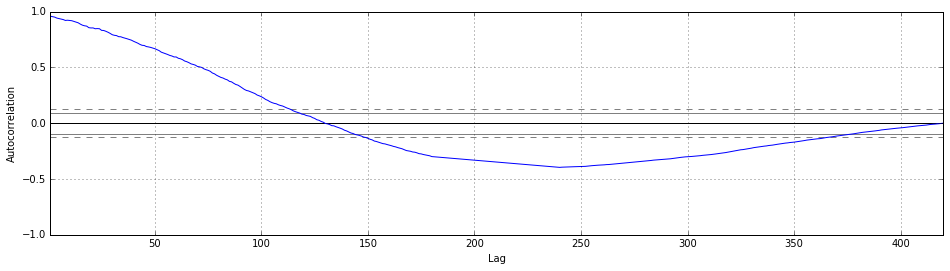

In [33]:
# Test for ramdomness: Autocorrelation plot - Florida

autocorrelation_plot(my_series['Florida'])

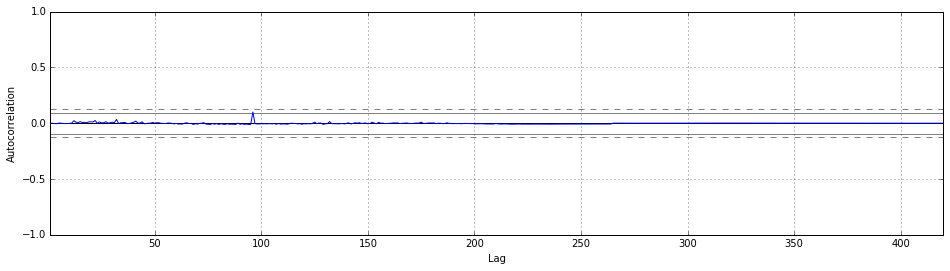

In [34]:
autocorrelation_plot(my_series['Alabama'])

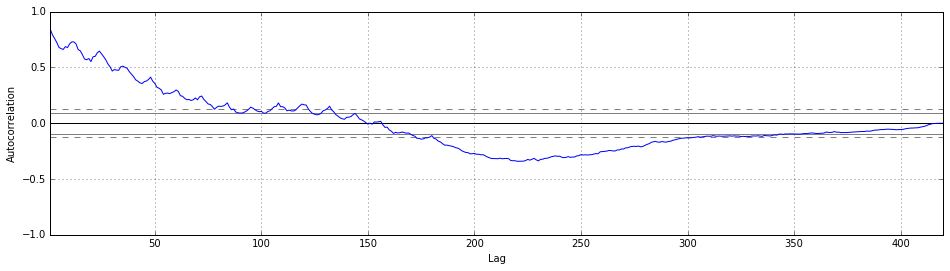

In [35]:
autocorrelation_plot(my_series['California'])

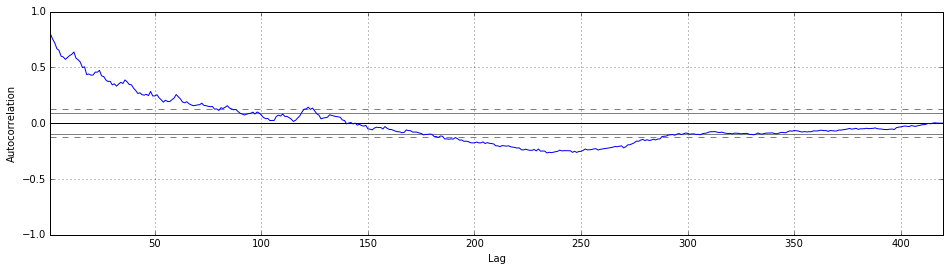

In [36]:
autocorrelation_plot(my_series['Texas'])

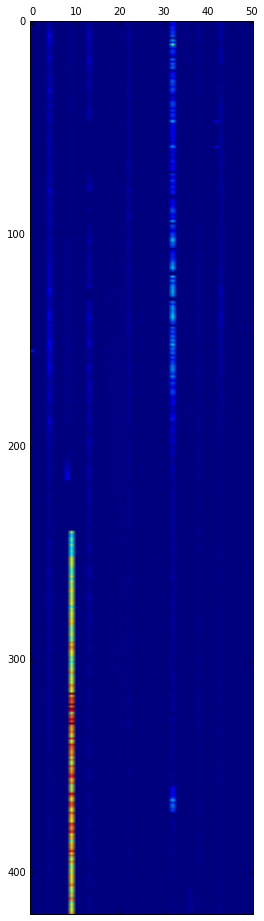

In [37]:
# Some states (6) are distinct

plt.matshow(my_series, interpolation=None, aspect='auto')